# VDB inference

In [22]:
# === Framework Cell: Initialization for All Experiments ===

!pip install datasets faiss-cpu plotly

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import time
import os
import json
from datetime import datetime
import pickle

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Dataset loading function
def load_sst2():
    dataset = load_dataset("glue", "sst2")
    return dataset['train']['sentence'], dataset['train']['label'], dataset['validation']['sentence'], dataset['validation']['label']

# Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False
bert.to(device)

# Tokenization caching for reuse
def tokenize_and_cache(texts, prefix="train"):
    cache_path = f"/content/drive/MyDrive/ds/attention_vdb_cache/{prefix}_tokens.pkl"
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with open(cache_path, "wb") as f:
        pickle.dump(encoded, f)
    return encoded

# CLS-based embedding extractor
def extract_embeddings(texts):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            outputs = bert(**inputs).last_hidden_state[:, 0, :]
            all_embeddings.append(outputs.cpu())
    return torch.cat(all_embeddings, dim=0)

# General model encoding interface
def encode_dataset(texts, model):
    vectors = []
    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            vec = model(inputs['input_ids'], inputs['attention_mask'])
            # vec, _ = model(inputs['input_ids'], inputs['attention_mask'])
            vectors.append(vec.cpu())
    return torch.cat(vectors, dim=0).numpy()

# Logging to persistent file
LOG_FILE = "/content/drive/MyDrive/ds/attention_vdb_experiments.jsonl"

# Logging experiment summary
def log_experiment_results(uid, method_description, report_dict, runtime_seconds):
    record = {
        "uid": uid,
        "date": datetime.now().isoformat(),
        "method": method_description,
        "accuracy": report_dict.get("accuracy", None),
        "macro_f1": report_dict.get("macro avg", {}).get("f1-score", None),
        "weighted_f1": report_dict.get("weighted avg", {}).get("f1-score", None),
        "runtime_sec": runtime_seconds
    }
    os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
    with open(LOG_FILE, "a") as f:
        f.write(json.dumps(record) + "\n")

# Logging summary viewer
def view_logged_experiments():
    if not os.path.exists(LOG_FILE):
        print("No log file found.")
        return
    with open(LOG_FILE) as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    return df.sort_values(by="date", ascending=False).reset_index(drop=True)

# Evaluation and persistence for reuse
def evaluate_model(model, train_texts, train_labels, test_texts, test_labels, title="Model Evaluation", uid="default", method_desc="N/A", save_embeddings=False):
    start_time = time.time()
    train_vecs = encode_dataset(train_texts, model)
    test_vecs = encode_dataset(test_texts, model)
    fit_time = time.time() - start_time

    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(train_vecs, train_labels)
    pred_labels = classifier.predict(test_vecs)

    report = classification_report(test_labels, pred_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print(f"\nClassification Report ({title}):")
    print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

    conf_matrix = confusion_matrix(test_labels, pred_labels)
    fig = px.imshow(conf_matrix,
                    labels=dict(x="Predicted", y="True", color="Count"),
                    x=['Negative', 'Positive'],
                    y=['Negative', 'Positive'],
                    text_auto=True,
                    title=f"Confusion Matrix: {title}")
    fig.show()

    # Show examples of misclassified instances
    misclassified = [(t, p, l) for t, p, l in zip(test_texts, pred_labels, test_labels) if p != l]
    print("\nExample misclassifications:")
    for i, (text, pred, label) in enumerate(misclassified[:3]):
        print(f"[{i+1}] True: {label} | Pred: {pred} | Text: {text[:150]}...")

    print(f"\nBenchmark: Total encoding + kNN time: {fit_time:.2f} seconds")
    log_experiment_results(uid, method_desc, report, fit_time)

    # Save embeddings and metadata for future stages
    if save_embeddings:
        os.makedirs("/content/drive/MyDrive/ds/attention_vdb_embeddings", exist_ok=True)
        np.save(f"/content/drive/MyDrive/ds/attention_vdb_embeddings/{uid}_train.npy", train_vecs)
        np.save(f"/content/drive/MyDrive/ds/attention_vdb_embeddings/{uid}_test.npy", test_vecs)
        metadata = [
            {"id": i, "text": t, "true": int(y), "pred": int(p), "error": int(y != p)}
            for i, (t, y, p) in enumerate(zip(test_texts, test_labels, pred_labels))
        ]
        with open(f"/content/drive/MyDrive/ds/attention_vdb_embeddings/{uid}_metadata.pkl", "wb") as f:
            pickle.dump(metadata, f)

    return report_df, fit_time



Mounted at /content/drive


- Добавить примеры аномалий.
- Вывести отдельно подготовку данных и анализ в отдельные методы
- Сохранять данные и модели на google Диск для анализа. Сохранять в JSONL для обработки обобщений. Интегрировать описательные параметры в JSONL: Название, описание метода. UID - Название метода, итериация - дата исполнения. Сейчас в блокноте данные отображаются, но сводную информацию обрабатывать нельзя.
- Benchmark
- Сформировать феймворк и перезапустить исполнение всех методов.

References:
[Text Classification on GLUE SST2](https://paperswithcode.com/sota/text-classification-on-glue-sst2)

In [2]:
view_logged_experiments()

,uid,date,method,accuracy,macro_f1,weighted_f1,runtime_sec
0,tokreg_v2,2025-04-14T10:12:56.509372,Triplet-trained attention derived from tokreg_...,0.752294,0.751340,0.751623,156.860917
1,tokreg_v2,2025-04-14T10:05:59.286536,Triplet-trained attention on tokreg_v1 error z...,0.733945,0.731908,0.732337,157.624442
2,tokreg_v1,2025-04-14T09:57:34.416880,Token-level attention with stopword regulariza...,0.870413,0.870364,0.870410,154.735439
3,tokreg_v1,2025-04-14T08:53:25.812880,Token-level attention with stopword regulariza...,0.854358,0.854123,0.854230,155.489830
4,tokreg_v1,2025-04-14T08:27:14.825945,Token-level attention with stopword regulariza...,0.866972,0.866888,0.866949,154.832543


# Error-Aware Adaptation

## Error analisys

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sst2' at /root/.cache/huggingface/datasets/glue/sst2/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Mon Apr 14 06:30:06 2025).



Error 1:
Text      : pumpkin takes an admirable look at the hypocrisy of political correctness , but it does so with such an uneven tone that you never know when humor end...
True / Pred: 0 / 1
Neighbor errors: 1
Neighbor labels: [0, 0, 1, 1]

Error 2:
Text      : holden caulfield did it better . ...
True / Pred: 0 / 1
Neighbor errors: 0
Neighbor labels: [1, 1, 1, 1]

Error 3:
Text      : it 's a cookie-cutter movie , a cut-and-paste job . ...
True / Pred: 0 / 1
Neighbor errors: 2
Neighbor labels: [1, 0, 0, 0]


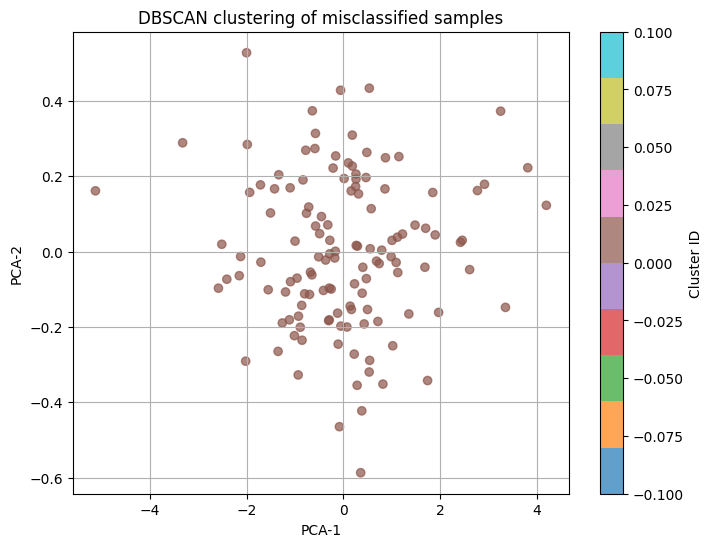

In [ ]:
import faiss
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from datasets import load_dataset

# Load SST-2 validation set
sst2 = load_dataset("glue", "sst2")
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']
train_labels = sst2['train']['label']

# Load saved embeddings (paths must exist)
train_vecs = np.load("/content/drive/MyDrive/attention_vdb_embeddings/tokreg_v1_train.npy")
test_vecs = np.load("/content/drive/MyDrive/attention_vdb_embeddings/tokreg_v1_test.npy")

# Predict using stored model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_vecs, train_labels)
pred_labels = knn.predict(test_vecs)

# Metadata for all validation examples
metadata = [
    {
        "id": i,
        "text": text,
        "true": int(true),
        "pred": int(pred),
        "error": int(true != pred)
    }
    for i, (text, true, pred) in enumerate(zip(test_texts, test_labels, pred_labels))
]

# Build FAISS index and search for neighborhoods
index = faiss.IndexFlatL2(test_vecs.shape[1])
index.add(test_vecs)
error_indices = [m["id"] for m in metadata if m["error"]]
error_vectors = test_vecs[error_indices]
_, neighbor_ids = index.search(error_vectors, 5)

# Structure neighborhood analysis
error_analysis = []
for err_id, neighbors in zip(error_indices, neighbor_ids):
    error_point = metadata[err_id]
    neighbors_data = [metadata[n] for n in neighbors if n != err_id]
    error_analysis.append({
        "error_id": err_id,
        "text": error_point["text"],
        "true": error_point["true"],
        "pred": error_point["pred"],
        "neighbors": neighbors_data
    })

# Preview a few results
for i, sample in enumerate(error_analysis[:3]):
    print(f"\nError {i+1}:")
    print(f"Text      : {sample['text'][:150]}...")
    print(f"True / Pred: {sample['true']} / {sample['pred']}")
    print("Neighbor errors:", sum(n['error'] for n in sample['neighbors']))
    print("Neighbor labels:", [n['true'] for n in sample['neighbors']])

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Reduce dimension of error embeddings
from sklearn.preprocessing import StandardScaler

error_vecs = test_vecs[error_indices]
reduced = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(error_vecs))

# Apply DBSCAN to error vectors
db = DBSCAN(eps=2.0, min_samples=5).fit(reduced)
labels = db.labels_

# Visualize
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("DBSCAN clustering of misclassified samples")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster ID")
plt.show()


# token_signal_expansion
Обучаем во взаимодействии с LLM

# Пробуем обучение на опыте

### Train Contrastive Attention

In [7]:
# MVP: Token-conditioned contrastive set training (discover latent trigger entities per error)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import os

# Define contrastive attention encoder
class ContrastiveAttentionEncoder(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.att = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            hidden = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        scores = self.att(hidden).squeeze(-1)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        pooled = torch.sum(hidden * weights.unsqueeze(-1), dim=1)
        return pooled

# Training function for contrastive attention
class ContrastiveTripletDataset(Dataset):
    def __init__(self, triplets, tokenizer):
        self.triplets = triplets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        ta = self.tokenizer(a, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tp = self.tokenizer(p, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tn = self.tokenizer(n, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        return {
            'a_input_ids': ta['input_ids'].squeeze(0),
            'a_attention_mask': ta['attention_mask'].squeeze(0),
            'p_input_ids': tp['input_ids'].squeeze(0),
            'p_attention_mask': tp['attention_mask'].squeeze(0),
            'n_input_ids': tn['input_ids'].squeeze(0),
            'n_attention_mask': tn['attention_mask'].squeeze(0)
        }

def train_contrastive_on_token_sets(model, triplets, tokenizer, device):
    model.to(device)
    dataset = ContrastiveTripletDataset(triplets, tokenizer)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)

    model.train()
    for epoch in range(10):
        total_loss = 0
        for batch in loader:
            a_ids = batch['a_input_ids'].to(device)
            a_mask = batch['a_attention_mask'].to(device)
            p_ids = batch['p_input_ids'].to(device)
            p_mask = batch['p_attention_mask'].to(device)
            n_ids = batch['n_input_ids'].to(device)
            n_mask = batch['n_attention_mask'].to(device)

            a_vec = model(a_ids, a_mask)
            p_vec = model(p_ids, p_mask)
            n_vec = model(n_ids, n_mask)

            loss = criterion(a_vec, p_vec, n_vec)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {total_loss / len(loader):.4f}")
    return model

# Load metadata and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
with open("/content/drive/MyDrive/ds/attention_vdb_embeddings/tokreg_v1_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

# Step 1: For each error, extract its tokens
token_to_examples = defaultdict(lambda: {"positive": [], "negative": []})
for m in metadata:
    encoded = tokenizer(m['text'], return_tensors="pt", truncation=True, max_length=128)
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])
    base_tokens = [t for t in tokens if not t.startswith("[") and not t.startswith("##")]
    for t in base_tokens:
        label = "negative" if m['error'] else "positive"
        token_to_examples[t][label].append(m['text'])

# Step 2: Build contrastive batches from token-conditioned groups
contrastive_sets = []
for token, ex in token_to_examples.items():
    pos_set = ex['positive']
    neg_set = ex['negative']
    if len(pos_set) >= 2 and len(neg_set) >= 2:
        for _ in range(3):
            anchor, positive = np.random.choice(pos_set, 2, replace=False)
            negative = np.random.choice(neg_set)
            contrastive_sets.append((anchor, positive, negative))

print(f"Built {len(contrastive_sets)} contrastive samples across {len(token_to_examples)} unique trigger tokens.")

# Step 3: Train attention module on this contrastive corpus
bert = AutoModel.from_pretrained("bert-base-uncased")
attention_encoder = ContrastiveAttentionEncoder(bert, hidden_size=768)
attention_encoder = train_contrastive_on_token_sets(attention_encoder, contrastive_sets, tokenizer, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Step 4: Save trained attention weights
torch.save(attention_encoder.state_dict(), "/content/drive/MyDrive/ds/attention_vdb_embeddings/contrastive_attention_weights.pt")
print("Saved contrastive attention weights to disk.")

Built 663 contrastive samples across 3669 unique trigger tokens.
Epoch 1 Loss: 1.0432
Epoch 2 Loss: 1.0254
Epoch 3 Loss: 0.9857
Epoch 4 Loss: 0.9862
Epoch 5 Loss: 0.9435
Epoch 6 Loss: 0.9210
Epoch 7 Loss: 0.9165
Epoch 8 Loss: 0.8904
Epoch 9 Loss: 0.8513
Epoch 10 Loss: 0.8448
Saved contrastive attention weights to disk.


### Evaluation of Contrastive-Tuned Attention + Token-Level Attention Regularization

In [17]:
# Experiment: Evaluation of Contrastive-Tuned Attention + Token-Level Attention Regularization

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import pickle
import os

# Load tokenizer and base BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for p in bert.parameters():
    p.requires_grad = False
bert.eval()

# Rebuild the same encoder class used during training
class ContrastiveAttentionEncoder(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.att = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask):
        scores = self.att(hidden_states).squeeze(-1)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = torch.softmax(scores, dim=-1)
        pooled = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return pooled, weights

class CombinedAttentionModel(nn.Module):
    def __init__(self, base_model, attention_pooler, hidden_size):
        super().__init__()
        self.bert = base_model
        self.attn = attention_pooler
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            hidden_states = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled, weights = self.attn(hidden_states, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# Load SST-2 data
train_texts, train_labels, test_texts, test_labels = load_sst2()

# Load full contrastive-trained encoder
full_encoder = ContrastiveAttentionEncoder(bert=bert, hidden_size=768)
full_encoder.load_state_dict(torch.load("/content/drive/MyDrive/ds/attention_vdb_embeddings/contrastive_attention_weights.pt"))

# Build model with full contrastive attention encoder
combined_model = CombinedAttentionModel(base_model=bert, attention_pooler=full_encoder, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model.to(device)

# Fine-tune classifier only
class SST2Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = SST2Dataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(combined_model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

combined_model.train()
for epoch in range(5):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = combined_model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluate and log results
uid = "tokreg_contrastive"
desc = "Token-level attention regularization + Contrastive Attention-tuned head"
evaluate_model(
    model=combined_model,
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Evaluation: tokreg_v1 + contrastive attention",
    uid=uid,
    method_desc=desc,
    save_embeddings=True
)


Epoch 1 Loss: 0.3903
Epoch 2 Loss: 0.3195
Epoch 3 Loss: 0.3108
Epoch 4 Loss: 0.3052
Epoch 5 Loss: 0.3033


AttributeError: 'tuple' object has no attribute 'cpu'

In [20]:
evaluate_model(
    model=combined_model,
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Evaluation: tokreg_v1 + contrastive attention",
    uid=uid,
    method_desc=desc,
    save_embeddings=True
)


Classification Report (Evaluation: tokreg_v1 + contrastive attention):
              precision    recall  f1-score     support
0              0.893365  0.880841  0.887059  428.000000
1              0.886667  0.898649  0.892617  444.000000
accuracy       0.889908  0.889908  0.889908    0.889908
macro avg      0.890016  0.889745  0.889838  872.000000
weighted avg   0.889954  0.889908  0.889889  872.000000



Example misclassifications:
[1] True: 0 | Pred: 1 | Text: holden caulfield did it better . ...
[2] True: 0 | Pred: 1 | Text: ... designed to provide a mix of smiles and tears , `` crossroads '' instead provokes a handful of unintentional howlers and numerous yawns . ...
[3] True: 0 | Pred: 1 | Text: the cold turkey would 've been a far better title . ...

Benchmark: Total encoding + kNN time: 161.88 seconds


(              precision    recall  f1-score     support
 0              0.893365  0.880841  0.887059  428.000000
 1              0.886667  0.898649  0.892617  444.000000
 accuracy       0.889908  0.889908  0.889908    0.889908
 macro avg      0.890016  0.889745  0.889838  872.000000
 weighted avg   0.889954  0.889908  0.889889  872.000000,
 161.87722754478455)

## Attention-Guided VBD Inference: Token-Level Trigger Learning (MVP)

### Объектная модель

In [4]:
# Attention-Guided VBD Inference: Token-Level Trigger Learning (MVP)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import random
import os
import pickle

# Load base tokenizer and frozen BERT
bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
bert = AutoModel.from_pretrained(bert_name)
for p in bert.parameters():
    p.requires_grad = False
bert.eval()

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)

# Custom attention pooling layer
class TriggerAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.att = nn.Linear(hidden_size, 1)

    def forward(self, embeddings, mask):
        scores = self.att(embeddings).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(embeddings * weights.unsqueeze(-1), dim=1)
        return output, weights

# Wrapper model for attention learning
class TripletAttentionEncoder(nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.bert = base_model
        self.pool = TriggerAttention(hidden_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            hidden = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled, weights = self.pool(hidden, attention_mask)
        return pooled, weights

# Triplet Dataset from tokenized input
class TripletTextDataset(Dataset):
    def __init__(self, triplets, tokenizer):
        self.triplets = triplets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        ta = self.tokenizer(a, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tp = self.tokenizer(p, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tn = self.tokenizer(n, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        return {
            'a_input_ids': ta['input_ids'].squeeze(0),
            'a_attention_mask': ta['attention_mask'].squeeze(0),
            'p_input_ids': tp['input_ids'].squeeze(0),
            'p_attention_mask': tp['attention_mask'].squeeze(0),
            'n_input_ids': tn['input_ids'].squeeze(0),
            'n_attention_mask': tn['attention_mask'].squeeze(0)
        }

# Triplet generation from VBD metadata
def build_triplets_from_errors(meta, embeddings):
    triplets = []
    err_meta = [m for m in meta if m['error']]
    err_vecs = np.array([embeddings[m['id']] for m in err_meta])
    sim = cosine_similarity(err_vecs, embeddings)

    for i, m in enumerate(err_meta):
        anchor = m['text']
        pos_cands = [j for j, t in enumerate(meta) if t['true'] == m['true'] and not t['error'] and j != m['id']]
        neg_cands = [j for j, t in enumerate(meta) if t['true'] != m['true']]
        if not pos_cands or not neg_cands:
            continue
        pos = meta[random.choice(pos_cands)]['text']
        neg = meta[random.choice(neg_cands)]['text']
        triplets.append((anchor, pos, neg))
    return triplets

# Train attention model with triplet loss
def train_attention_on_triplets(model, triplets, tokenizer, device, epochs=10):
    dataset = TripletTextDataset(triplets, tokenizer)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)

    model.train()
    model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(loader):
            a = model(batch['a_input_ids'].to(device), batch['a_attention_mask'].to(device))[0]
            p = model(batch['p_input_ids'].to(device), batch['p_attention_mask'].to(device))[0]
            n = model(batch['n_input_ids'].to(device), batch['n_attention_mask'].to(device))[0]
            loss = criterion(a, p, n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(loader):.4f}")
    return model

# Save weights or attention scores for interpretation

def extract_attention_weights(model, text_batch, tokenizer):
    model.eval()
    batch = tokenizer(text_batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    _, weights = model(batch['input_ids'], batch['attention_mask'])
    weights = weights.detach().cpu().numpy()
    tokens = [tokenizer.convert_ids_to_tokens(seq) for seq in batch['input_ids'].cpu().numpy()]
    return list(zip(tokens, weights))


### Апробация
эмпирическое подтверждение того, что attention-модуль может научиться «замечать» то, что вызывает ошибки.

In [ ]:
# VBD → Attention Learner → Explanation → Query Refinement Pipeline

import numpy as np
import json
import pickle
from transformers import AutoTokenizer, AutoModel

# Load base tokenizer and frozen BERT again
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for p in bert.parameters():
    p.requires_grad = False
bert.eval()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)

# Load metadata and embeddings from previous run
with open("/content/drive/MyDrive/attention_vdb_embeddings/tokreg_v1_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

test_vecs = np.load("/content/drive/MyDrive/attention_vdb_embeddings/tokreg_v1_test.npy")

# Step 1: Build training triplets from misclassified regions
triplets = build_triplets_from_errors(metadata, test_vecs)
print(f"Generated {len(triplets)} training triplets from error zones.")

# Step 2: Initialize and train attention model on these triplets
attention_model = TripletAttentionEncoder(bert, hidden_size=768)
attention_model = train_attention_on_triplets(attention_model, triplets, tokenizer, device)

# Step 3: Extract attention-weighted tokens for selected misclassified cases
error_texts = [m['text'] for m in metadata if m['error']][:5]
explanations = extract_attention_weights(attention_model, error_texts, tokenizer)

# Display explanations for first few cases
for i, (tokens, weights) in enumerate(explanations[:3]):
    print(f"\nExample {i+1}:")
    for tok, w in zip(tokens, weights):
        print(f"{tok:15} -> {w:.3f}")


Generated 113 training triplets from error zones.


100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


Epoch 1 Loss: 1.1909


100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

Epoch 2 Loss: 1.1705

Example 1:
[CLS]           -> 0.132
holden          -> 0.107
ca              -> 0.094
##ulf           -> 0.071
##ield          -> 0.085
did             -> 0.099
it              -> 0.077
better          -> 0.102
.               -> 0.117
[SEP]           -> 0.115
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -> 0.000
[PAD]           -

## Fine-tuned Attention (tokreg_v2) using Triplet-guided Reweighting
Не удача. Не верная выборка для обучения триплетов

In [25]:
''' # Experiment: Fine-tuned Attention (tokreg_v2) combining Token-Level Regularization with Triplet-based Reweighting

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import pickle
import os
import plotly.express as px

# Config
uid = "tokreg_v2"
desc = "Token-level attention regularization + Triplet-guided fine-tuning on tokreg_v1 error regions"

# Load tokenizer and BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for p in bert.parameters():
    p.requires_grad = False
bert.eval()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)

# Load SST2 and tokreg_v1 metadata/embeddings
train_texts, train_labels, test_texts, test_labels = load_sst2()
test_vecs = np.load("/content/drive/MyDrive/ds/attention_vdb_embeddings/tokreg_v1_test.npy")
train_vecs = np.load("/content/drive/MyDrive/ds/attention_vdb_embeddings/tokreg_v1_train.npy")
with open("/content/drive/MyDrive/ds/attention_vdb_embeddings/tokreg_v1_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

# === Define Compatible Attention Layer ===
class TokenTripletAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.att = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask):
        scores = self.att(hidden_states).squeeze(-1)
        scores = scores.masked_fill(attention_mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        pooled = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return pooled, weights

class CombinedAttentionModel(nn.Module):
    def __init__(self, base_model, attention_pooler, hidden_size):
        super().__init__()
        self.bert = base_model
        self.attn = attention_pooler
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled, weights = self.attn(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# === Step 1: Initial attention training with triplet loss ===
triplets = build_triplets_from_errors(metadata, test_vecs)
print(f"Generated {len(triplets)} training triplets from error zones.")
if len(triplets) == 0:
    raise ValueError("No triplets generated from metadata. Check metadata format or error logic.")

attention_encoder = TripletAttentionEncoder(bert, hidden_size=768)
attention_encoder = train_attention_on_triplets(attention_encoder, triplets, tokenizer, device, 15)

# === Step 2: Reuse attention weights in classifier ===
attention_pooler = TokenTripletAttention(hidden_size=768)
attention_pooler.load_state_dict({
    "att.weight": attention_encoder.pool.state_dict()["att.weight"],
    "att.bias": attention_encoder.pool.state_dict()["att.bias"]
})

combined_model = CombinedAttentionModel(base_model=bert, attention_pooler=attention_pooler, hidden_size=768)
combined_model.to(device)

# === Step 3: Fine-tune classifier with frozen BERT and tuned attention ===
class SST2Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = SST2Dataset(train_texts, train_labels, tokenizer)
test_dataset = SST2Dataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(combined_model.parameters(), lr=2e-4)
ce_loss = nn.CrossEntropyLoss()

combined_model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, weights = combined_model(input_ids, attention_mask)
        loss = ce_loss(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

# === Step 4: Evaluation using attention wrapper ===
class AttentionOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            logits, _ = self.model(input_ids, attention_mask)
            return logits.argmax(dim=1)

# Rebuild encoder output for kNN evaluation
evaluate_model(
    model=combined_model,
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Token-level Regularized + Triplet Attention (tokreg_v2)",
    uid=uid,
    method_desc=desc,
    save_embeddings=True
) '''

Generated 113 training triplets from error zones.


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 1 Loss: 1.1183


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 2 Loss: 1.0463


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 3 Loss: 1.2043


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 4 Loss: 1.1494


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Epoch 5 Loss: 1.0263


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch 6 Loss: 1.1589


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 7 Loss: 1.1705


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 8 Loss: 1.1800


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 9 Loss: 0.9927


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Epoch 10 Loss: 1.2572


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Epoch 11 Loss: 1.1641


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Epoch 12 Loss: 1.0881


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 13 Loss: 1.2168


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Epoch 14 Loss: 0.9466


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Epoch 15 Loss: 1.2081


KeyboardInterrupt: 

# Search-Driven Inference - Baseline

## accuracy       0.759174. No attantion

In [ ]:
# Re-import required libraries after environment reset
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
from datasets import load_dataset

# Load dataset (SST2)
dataset = load_dataset("glue", "sst2")
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]
test_texts = dataset["validation"]["sentence"]
test_labels = dataset["validation"]["label"]

# Load tokenizer and model (BERT base, uncased)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()


# Function to extract CLS embedding from BERT
def get_cls_embedding(texts, tokenizer, model):
    embeddings = []
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_tokens = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_tokens)
    return np.vstack(embeddings)


# Generate embeddings for train and test sets
train_embeddings = get_cls_embedding(train_texts, tokenizer, model)
test_embeddings = get_cls_embedding(test_texts, tokenizer, model)

# Build FAISS index
dimension = train_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(train_embeddings)

# Perform k-NN search
k = 5
distances, indices = index.search(test_embeddings, k)

# Predict based on majority vote of k nearest neighbors
predicted_labels = []
for i in range(len(indices)):
    neighbor_labels = [train_labels[idx] for idx in indices[i]]
    majority_vote = max(set(neighbor_labels), key=neighbor_labels.count)
    predicted_labels.append(majority_vote)

# Classification report
report = classification_report(test_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
selected_rows = ["0", "1", "accuracy", "macro avg", "weighted avg"]
print("\nClassification Report (VDB baseline using CLS token):")
print(report_df.loc[selected_rows])

# Confusion matrix visualization
conf_matrix = confusion_matrix(test_labels, predicted_labels)
fig = px.imshow(
    conf_matrix,
    labels=dict(x="Predicted Label", y="True Label", color="Count"),
    x=["Negative", "Positive"],
    y=["Negative", "Positive"],
    text_auto=True,
    title="Confusion Matrix: VDB Baseline (CLS Token)",
)

fig.show()

# Pretrained BERT attantion.
Worse then the raw VDB

## accuracy       0.740826

In [ ]:
# Добавляем предобученный модель внимания
# Результат - снижение точности
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
from datasets import load_dataset

# Load SST2 dataset
dataset = load_dataset("glue", "sst2")
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]
test_texts = dataset["validation"]["sentence"]
test_labels = dataset["validation"]["label"]

# Load tokenizer and model (BERT base, uncased)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()


# Function to extract embedding via self-attention refinement (mean of all token representations after last layer)
def get_attention_refined_embedding(texts, tokenizer, model):
    embeddings = []
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        attention_mask = inputs["attention_mask"]
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # Apply attention-aware mean pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        refined_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
        embeddings.append(refined_embeddings)
    return np.vstack(embeddings)


# Generate embeddings with attention-based refinement
train_embeddings = get_attention_refined_embedding(train_texts, tokenizer, model)
test_embeddings = get_attention_refined_embedding(test_texts, tokenizer, model)

# Build FAISS index
dimension = train_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(train_embeddings)

# Perform k-NN search
k = 5
distances, indices = index.search(test_embeddings, k)

# Predict based on majority vote of k nearest neighbors
predicted_labels = []
for i in range(len(indices)):
    neighbor_labels = [train_labels[idx] for idx in indices[i]]
    majority_vote = max(set(neighbor_labels), key=neighbor_labels.count)
    predicted_labels.append(majority_vote)

# Classification report
report = classification_report(test_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
selected_rows = ["0", "1", "accuracy", "macro avg", "weighted avg"]
print("\nClassification Report (VDB + Attention Refinement):")
print(report_df.loc[selected_rows])

# Confusion matrix visualization
conf_matrix = confusion_matrix(test_labels, predicted_labels)
fig = px.imshow(
    conf_matrix,
    labels=dict(x="Predicted Label", y="True Label", color="Count"),
    x=["Negative", "Positive"],
    y=["Negative", "Positive"],
    text_auto=True,
    title="Confusion Matrix: VDB + Attention Refinement",
)

fig.show()

# Experiment: Local Attention Tuning on Anomalies Only (Triplet Loss) with CUDA support and Evaluation

## ValueError: num_samples should be a positive integer value, but got num_samples=0

In [18]:
# Experiment: Local Attention Tuning on Anomalies Only (Triplet Loss) with CUDA support and Evaluation

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
from sklearn.cluster import DBSCAN

# 1. Load SST-2 dataset
dataset = load_dataset("glue", "sst2")
train_texts = dataset['train']['sentence']
train_labels = dataset['train']['label']
test_texts = dataset['validation']['sentence']
test_labels = dataset['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Simple embedding extractor (CLS pooling)
def extract_embeddings(texts, device):
    all_embeddings = []
    bert.to(device)
    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            outputs = bert(**inputs).last_hidden_state[:, 0, :]
            all_embeddings.append(outputs.cpu())
    return torch.cat(all_embeddings, dim=0)

# 4. Find anomalies using DBSCAN clustering
def detect_anomalies_dbscan(embeddings):
    clustering = DBSCAN(eps=2.0, min_samples=10).fit(embeddings)
    labels = clustering.labels_
    anomalies = np.where(labels == -1)[0].tolist()
    return anomalies

# 5. Create triplets for Triplet Loss
def build_triplets(texts, labels, anomalies):
    triplets = []
    for idx in anomalies:
        anchor = texts[idx]
        label = labels[idx]
        positives = [i for i in range(len(labels)) if labels[i] == label and i != idx]
        negatives = [i for i in range(len(labels)) if labels[i] != label]
        if not positives or not negatives:
            continue
        pos = texts[random.choice(positives)]
        neg = texts[random.choice(negatives)]
        triplets.append((anchor, pos, neg))
    return triplets

# 6. Trainable attention-pooling encoder
class AttentionEncoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.att = nn.Linear(hidden_size, 1)

    def forward(self, embeddings, mask):
        scores = self.att(embeddings).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        pooled = torch.sum(embeddings * weights.unsqueeze(-1), dim=1)
        return pooled

# 7. Full encoder with frozen BERT
class TripletAttentionModel(nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.bert = base_model
        self.pooler = AttentionEncoder(hidden_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            hidden = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pooler(hidden, attention_mask)
        return pooled

# 8. Triplet Dataset
class TripletDataset(Dataset):
    def __init__(self, triplets, tokenizer):
        self.triplets = triplets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        ta = self.tokenizer(a, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tp = self.tokenizer(p, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        tn = self.tokenizer(n, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        return {
            'a_input_ids': ta['input_ids'].squeeze(0),
            'a_attention_mask': ta['attention_mask'].squeeze(0),
            'p_input_ids': tp['input_ids'].squeeze(0),
            'p_attention_mask': tp['attention_mask'].squeeze(0),
            'n_input_ids': tn['input_ids'].squeeze(0),
            'n_attention_mask': tn['attention_mask'].squeeze(0)
        }

# 9. Prepare triplets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings = extract_embeddings(train_texts, device).numpy()
anomalies = detect_anomalies_dbscan(embeddings)
triplets = build_triplets(train_texts, train_labels, anomalies)
print(f"Selected {len(triplets)} DBSCAN-based triplets.")

if len(triplets) == 0:
    print("⚠️ No triplets found. Generating fallback dummy triplets for debug mode.")
    for i in range(min(100, len(train_texts) - 2)):
        anchor = train_texts[i]
        pos = train_texts[i + 1]
        neg = train_texts[i + 2]
        triplets.append((anchor, pos, neg))

# 10. Train loop
triplet_dataset = TripletDataset(triplets, tokenizer)
dataloader = DataLoader(triplet_dataset, batch_size=16, shuffle=True)

model = TripletAttentionModel(bert, hidden_size=768)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(dataloader):
        a_ids = batch['a_input_ids'].to(device)
        a_mask = batch['a_attention_mask'].to(device)
        p_ids = batch['p_input_ids'].to(device)
        p_mask = batch['p_attention_mask'].to(device)
        n_ids = batch['n_input_ids'].to(device)
        n_mask = batch['n_attention_mask'].to(device)

        a_vec = model(a_ids, a_mask)
        p_vec = model(p_ids, p_mask)
        n_vec = model(n_ids, n_mask)

        loss = triplet_loss(a_vec, p_vec, n_vec)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")

# 11. Evaluation via kNN
model.eval()
def encode_dataset(texts):
    vectors = []
    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            vec = model(inputs['input_ids'], inputs['attention_mask'])
            vectors.append(vec.cpu())
    return torch.cat(vectors, dim=0).numpy()

train_vecs = encode_dataset(train_texts)
test_vecs = encode_dataset(test_texts)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_vecs, train_labels)
pred_labels = knn.predict(test_vecs)

# 12. Report
report = classification_report(test_labels, pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Triplet-tuned Attention + kNN):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 13. Confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Triplet-tuned Attention + kNN")
fig.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np



# Silhouette score
silhouette = silhouette_score(projected, labels)

# Center-based analysis
center_0 = projected[labels == 0].mean(axis=0)
center_1 = projected[labels == 1].mean(axis=0)

intra_0 = np.mean(np.linalg.norm(projected[labels == 0] - center_0, axis=1))
intra_1 = np.mean(np.linalg.norm(projected[labels == 1] - center_1, axis=1))
intra_avg = (intra_0 + intra_1) / 2
inter = np.linalg.norm(center_0 - center_1)
ratio = intra_avg / inter

silhouette, intra_avg, inter, ratio


<ipython-input-19-65653e09819b>:12: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning:

invalid value encountered in divide

<ipython-input-19-65653e09819b>:13: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning:

invalid value encountered in divide



(np.float32(0.21172437), np.float32(nan), np.float32(nan), np.float32(nan))

# Extended Experiment: Two-Stage Attention with Fine-Tuned and Anomaly-Specific Heads with positional value
Повторный запуск дал иную точность. Нужно проверить его воспроизводимость

## accuracy       0.892202 Позиционные данные ухудшают результат

In [ ]:
# Extended Experiment: Two-Stage Attention with Fine-Tuned and Anomaly-Specific Heads with positional value
# Позиционные данные ухудшают результат
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Poolers
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

class AnomalyAttentionPooler(nn.Module):
    def __init__(self, hidden_size, max_len=128):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)
        self.positional = nn.Parameter(torch.randn(1, max_len, hidden_size))

    def forward(self, hidden_states, mask):
        if self.positional.shape[1] < hidden_states.shape[1]:
            raise ValueError("Positional encoding too short for input length.")
        hidden_states = hidden_states + self.positional[:, :hidden_states.shape[1], :]
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model with dual attention
class SentimentModelWithAnomaly(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.anomaly_pooler = AnomalyAttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size * 2, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        standard = self.pooler(outputs.last_hidden_state, attention_mask)
        refined = self.anomaly_pooler(outputs.last_hidden_state, attention_mask)
        combined = torch.cat([standard, refined], dim=-1)
        return self.classifier(combined)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train model with anomaly-aware attention
model = SentimentModelWithAnomaly(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Dual-Attention Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Dual-Attention Classifier")
fig.show()

100%|██████████| 2105/2105 [04:12<00:00,  8.34it/s]


Epoch 1, Loss: 0.4066


100%|██████████| 2105/2105 [04:15<00:00,  8.25it/s]


Epoch 2, Loss: 0.3275


100%|██████████| 2105/2105 [04:15<00:00,  8.24it/s]


Epoch 3, Loss: 0.3173

Classification Report (Dual-Attention Fine-tuned):
              precision    recall  f1-score     support
0              0.903382  0.873832  0.888361  428.000000
1              0.882096  0.909910  0.895787  444.000000
accuracy       0.892202  0.892202  0.892202    0.892202
macro avg      0.892739  0.891871  0.892074  872.000000
weighted avg   0.892544  0.892202  0.892142  872.000000


# Two-Stage Attention with Fine-Tuned and Anomaly-Specific Heads

## accuracy       0.888761. Визуализируем embeddings после attention

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 2105/2105 [04:30<00:00,  7.79it/s]


Epoch 1, Loss: 0.4016


100%|██████████| 2105/2105 [04:35<00:00,  7.64it/s]


Epoch 2, Loss: 0.3243


100%|██████████| 2105/2105 [04:35<00:00,  7.64it/s]


Epoch 3, Loss: 0.3154

Classification Report (Dual-Attention Fine-tuned):
              precision    recall  f1-score     support
0              0.904645  0.864486  0.884110  428.000000
1              0.874730  0.912162  0.893054  444.000000
accuracy       0.888761  0.888761  0.888761    0.888761
macro avg      0.889688  0.888324  0.888582  872.000000
weighted avg   0.889413  0.888761  0.888664  872.000000


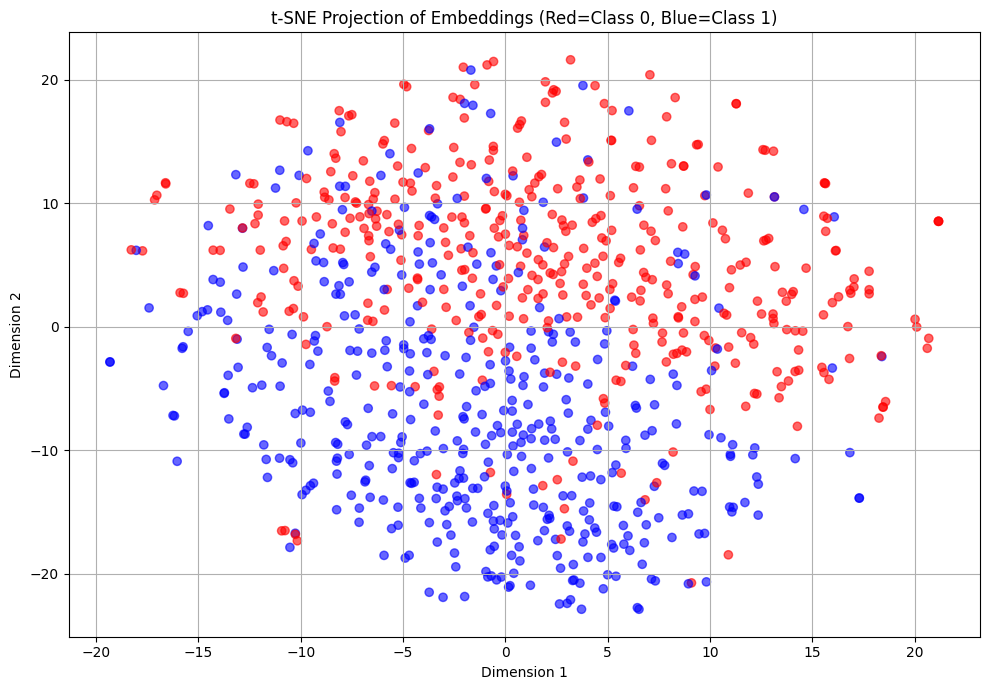

In [ ]:
## accuracy       0.888761. Визуализируем embeddings после attention
# Extended Experiment: Two-Stage Attention with Fine-Tuned and Anomaly-Specific Heads
# Визуализируем embeddings после attention

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Poolers
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

class AnomalyAttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model with dual attention
class SentimentModelWithAnomaly(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.anomaly_pooler = AnomalyAttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size * 2, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        standard = self.pooler(outputs.last_hidden_state, attention_mask)
        refined = self.anomaly_pooler(outputs.last_hidden_state, attention_mask)
        combined = torch.cat([standard, refined], dim=-1)
        return self.classifier(combined)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train model with anomaly-aware attention
model = SentimentModelWithAnomaly(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Dual-Attention Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Dual-Attention Classifier")
fig.show()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Вытащить embeddings после attention
embeddings, labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = model.pooler(output.last_hidden_state, attention_mask)
        embeddings.append(pooled.cpu())
        labels.extend(batch['labels'].numpy())
tsne = TSNE(n_components=2)
projected = tsne.fit_transform(torch.cat(embeddings).numpy())
# Визуализация
plt.figure(figsize=(10, 7))
colors = ['red' if l == 0 else 'blue' for l in labels]
plt.scatter(projected[:, 0], projected[:, 1], c=colors, alpha=0.6)
plt.title("t-SNE Projection of Embeddings (Red=Class 0, Blue=Class 1)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## Baseline. accuracy       0.897936

In [ ]:
# Extended Experiment: Two-Stage Attention with Fine-Tuned and Anomaly-Specific Heads

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Poolers
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

class AnomalyAttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model with dual attention
class SentimentModelWithAnomaly(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.anomaly_pooler = AnomalyAttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size * 2, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        standard = self.pooler(outputs.last_hidden_state, attention_mask)
        refined = self.anomaly_pooler(outputs.last_hidden_state, attention_mask)
        combined = torch.cat([standard, refined], dim=-1)
        return self.classifier(combined)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train model with anomaly-aware attention
model = SentimentModelWithAnomaly(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Dual-Attention Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Dual-Attention Classifier")
fig.show()

100%|██████████| 2105/2105 [04:10<00:00,  8.41it/s]


Epoch 1, Loss: 0.3982


100%|██████████| 2105/2105 [04:15<00:00,  8.24it/s]


Epoch 2, Loss: 0.3240


100%|██████████| 2105/2105 [04:15<00:00,  8.24it/s]


Epoch 3, Loss: 0.3151

Classification Report (Dual-Attention Fine-tuned):
              precision    recall  f1-score     support
0              0.908434  0.880841  0.894425  428.000000
1              0.888403  0.914414  0.901221  444.000000
accuracy       0.897936  0.897936  0.897936    0.897936
macro avg      0.898418  0.897628  0.897823  872.000000
weighted avg   0.898234  0.897936  0.897885  872.000000


# Full experimental pipeline with trainable attention pooler and frozen BERT

## accuracy       0.897936. Try 3. 10 Epoch

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 2105/2105 [04:28<00:00,  7.83it/s]


Epoch 1, Loss: 0.4330


100%|██████████| 2105/2105 [04:34<00:00,  7.67it/s]


Epoch 2, Loss: 0.3363


100%|██████████| 2105/2105 [04:32<00:00,  7.72it/s]


Epoch 3, Loss: 0.3212


100%|██████████| 2105/2105 [04:33<00:00,  7.70it/s]


Epoch 4, Loss: 0.3154


100%|██████████| 2105/2105 [04:34<00:00,  7.67it/s]


Epoch 5, Loss: 0.3102


100%|██████████| 2105/2105 [04:33<00:00,  7.71it/s]


Epoch 6, Loss: 0.3078


100%|██████████| 2105/2105 [04:33<00:00,  7.70it/s]


Epoch 7, Loss: 0.3055


100%|██████████| 2105/2105 [04:31<00:00,  7.74it/s]


Epoch 8, Loss: 0.3031


100%|██████████| 2105/2105 [04:33<00:00,  7.69it/s]


Epoch 9, Loss: 0.3012


100%|██████████| 2105/2105 [04:34<00:00,  7.68it/s]


Epoch 10, Loss: 0.3013

Classification Report (Attention-Pooler Fine-tuned):
              precision    recall  f1-score     support
0              0.902613  0.887850  0.895171  428.000000
1              0.893570  0.907658  0.900559  444.000000
accuracy       0.897936  0.897936  0.897936    0.897936
macro avg      0.898091  0.897754  0.897865  872.000000
weighted avg   0.898008  0.897936  0.897914  872.000000


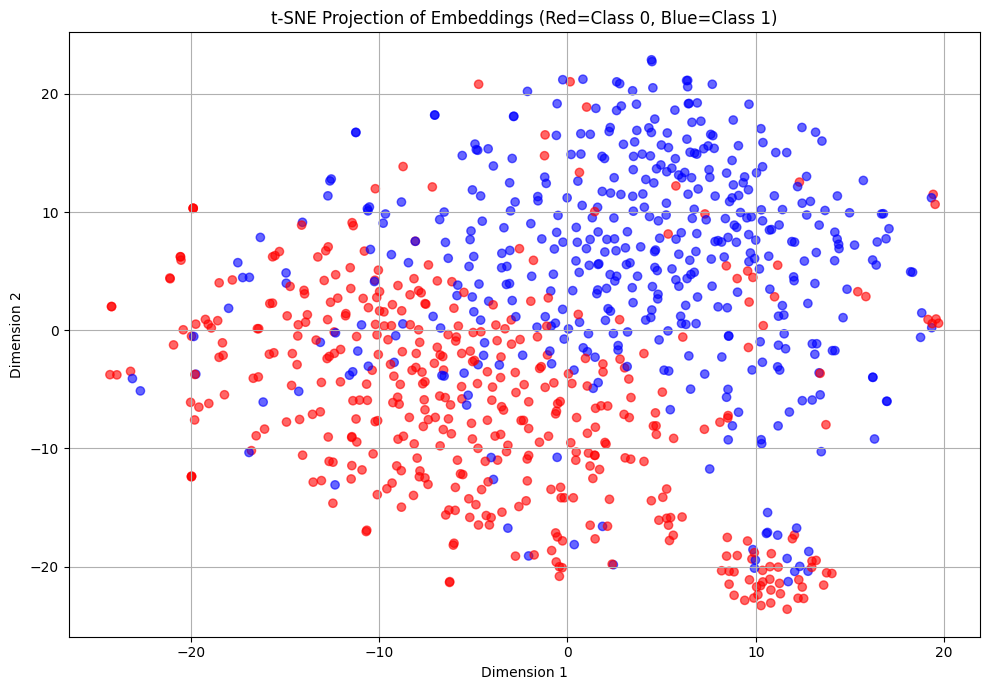

In [ ]:
# Full experimental pipeline with trainable attention pooler and frozen BERT

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Pooler
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model
class SentimentModel(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(pooled)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train attention pooler + classifier
model = SentimentModel(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(10):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Attention-Pooler Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Fine-tuned Attention-Pooler")
fig.show()
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Вытащить embeddings после attention
embeddings, labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = model.pooler(output.last_hidden_state, attention_mask)
        embeddings.append(pooled.cpu())
        labels.extend(batch['labels'].numpy())
tsne = TSNE(n_components=2)
projected = tsne.fit_transform(torch.cat(embeddings).numpy())
# Визуализация
plt.figure(figsize=(10, 7))
colors = ['red' if l == 0 else 'blue' for l in labels]
plt.scatter(projected[:, 0], projected[:, 1], c=colors, alpha=0.6)
plt.title("t-SNE Projection of Embeddings (Red=Class 0, Blue=Class 1)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## accuracy       0.905963  Try 2. Visualisation.

100%|██████████| 2105/2105 [04:35<00:00,  7.64it/s]


Epoch 1, Loss: 0.4399


100%|██████████| 2105/2105 [04:34<00:00,  7.66it/s]


Epoch 2, Loss: 0.3379


100%|██████████| 2105/2105 [04:34<00:00,  7.67it/s]


Epoch 3, Loss: 0.3225

Classification Report (Attention-Pooler Fine-tuned):
              precision    recall  f1-score     support
0              0.898618  0.911215  0.904872  428.000000
1              0.913242  0.900901  0.907029  444.000000
accuracy       0.905963  0.905963  0.905963    0.905963
macro avg      0.905930  0.906058  0.905951  872.000000
weighted avg   0.906064  0.905963  0.905971  872.000000


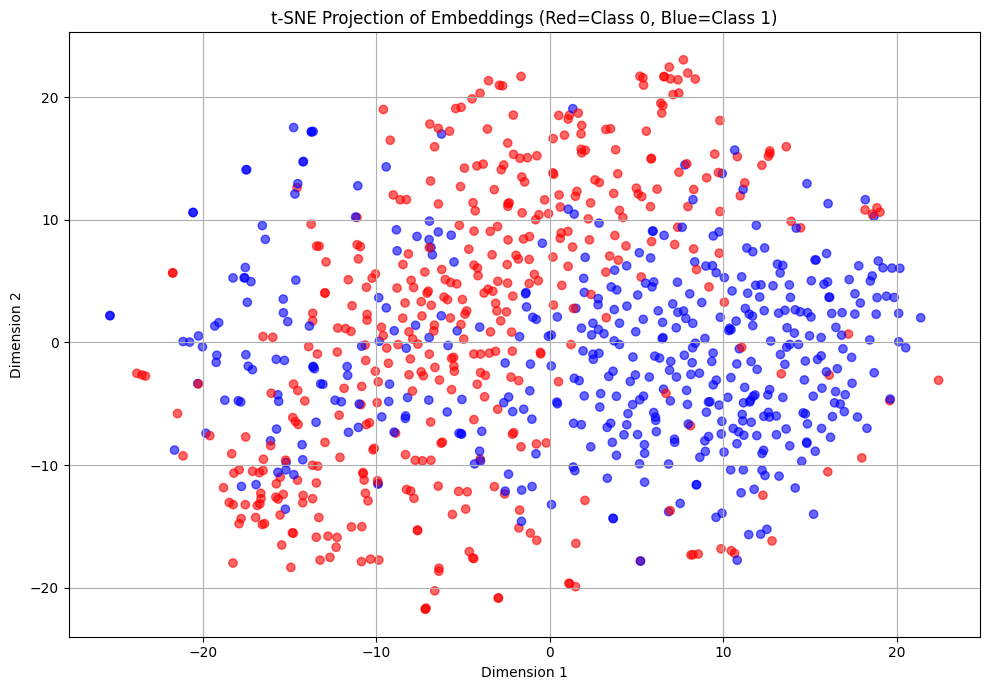

In [ ]:
# Full experimental pipeline with trainable attention pooler and frozen BERT

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Pooler
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model
class SentimentModel(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(pooled)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train attention pooler + classifier
model = SentimentModel(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Attention-Pooler Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Fine-tuned Attention-Pooler")
fig.show()
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Вытащить embeddings после attention
embeddings, labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = model.pooler(output.last_hidden_state, attention_mask)
        embeddings.append(pooled.cpu())
        labels.extend(batch['labels'].numpy())
tsne = TSNE(n_components=2)
projected = tsne.fit_transform(torch.cat(embeddings).numpy())
# Визуализация
plt.figure(figsize=(10, 7))
colors = ['red' if l == 0 else 'blue' for l in labels]
plt.scatter(projected[:, 0], projected[:, 1], c=colors, alpha=0.6)
plt.title("t-SNE Projection of Embeddings (Red=Class 0, Blue=Class 1)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## accuracy       0.894495

In [ ]:
# Full experimental pipeline with trainable attention pooler and frozen BERT

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Attention Pooler
class AttentionPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output

# 4. Classification model
class SentimentModel(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.pooler = AttentionPooler(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(pooled)

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Train attention pooler + classifier
model = SentimentModel(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# 8. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 9. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Attention-Pooler Fine-tuned):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 10. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Fine-tuned Attention-Pooler")
fig.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 2105/2105 [04:03<00:00,  8.66it/s]


Epoch 1, Loss: 0.4367


100%|██████████| 2105/2105 [04:15<00:00,  8.25it/s]


Epoch 2, Loss: 0.3341


100%|██████████| 2105/2105 [04:15<00:00,  8.25it/s]


Epoch 3, Loss: 0.3202

Classification Report (Attention-Pooler Fine-tuned):
              precision    recall  f1-score     support
0              0.901914  0.880841  0.891253  428.000000
1              0.887665  0.907658  0.897550  444.000000
accuracy       0.894495  0.894495  0.894495    0.894495
macro avg      0.894790  0.894249  0.894402  872.000000
weighted avg   0.894659  0.894495  0.894459  872.000000


# Native LLM. BertForSequenceClassification

## accuracy       0.924312

In [ ]:
# Чистая LLM
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import pandas as pd

# 1. Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# Загрузка той же архитектуры с дообученной головой
model_cls = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")
model_cls.eval()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Предсказание на test_texts
batch_size = 32
predicted_labels = []

with torch.no_grad():
    for i in range(0, len(test_texts), batch_size):
        batch = test_texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=128)
        outputs = model_cls(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())

# Оценка
report = classification_report(test_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
selected_rows = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']
print("\nClassification Report (LLM BERT-base fine-tuned on SST-2):")
print(report_df.loc[selected_rows])

# Визуализация
conf_matrix = confusion_matrix(test_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: BERT-base Fine-tuned SST-2")

fig.show()

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]


Classification Report (LLM BERT-base fine-tuned on SST-2):
              precision    recall  f1-score     support
0              0.930952  0.913551  0.922170  428.000000
1              0.918142  0.934685  0.926339  444.000000
accuracy       0.924312  0.924312  0.924312    0.924312
macro avg      0.924547  0.924118  0.924255  872.000000
weighted avg   0.924429  0.924312  0.924293  872.000000


# Experiment: Token-level Attention Regularization

## 8 Epoches

In [21]:
# Experiment Group: Error-Aware Adaptation
# Experiment Name: Token-level Attention Regularization (Framework-compatible)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm import tqdm
from datetime import datetime

# Load dataset
train_texts, train_labels, test_texts, test_labels = load_sst2()

# Prepare tokenized dataset using framework cache
train_tokens = tokenize_and_cache(train_texts, prefix="train")
test_tokens = tokenize_and_cache(test_texts, prefix="test")

# Dataset wrapper
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = TextDataset(train_tokens, train_labels)
test_dataset = TextDataset(test_tokens, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Attention pooling layer
class AttentionWithRegularization(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output, weights

# Classification model with attention
class AttentionRegularizedClassifier(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.attn = AttentionWithRegularization(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled, weights = self.attn(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# Regularization function for attention weights
def attention_regularization(weights, input_ids):
    special_ids = set(tokenizer.convert_tokens_to_ids(['[PAD]', '[CLS]', '[SEP]']))
    penalty = 0
    for i, row in enumerate(input_ids):
        mask = torch.tensor([1.0 if tok in special_ids else 0.0 for tok in row])
        penalty += torch.sum(weights[i] * mask.to(weights.device))
    return penalty / weights.size(0)

# Model setup
model = AttentionRegularizedClassifier(bert, hidden_size=768)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(8):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, weights = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        reg = attention_regularization(weights, input_ids)
        loss = loss + 0.1 * reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Evaluation wrapper
class EmbeddingWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            logits, _ = self.model(input_ids, attention_mask)
            return logits

# Register evaluation in framework
evaluate_model(
    model=EmbeddingWrapper(model),
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Token-Level Attention Regularization",
    uid="tokreg_v1",
    method_desc="Token-level attention with stopword regularization",
    save_embeddings=True
)


100%|██████████| 2105/2105 [04:30<00:00,  7.78it/s]


Epoch 1: Loss = 0.4491


100%|██████████| 2105/2105 [04:28<00:00,  7.83it/s]


Epoch 2: Loss = 0.3429


100%|██████████| 2105/2105 [04:26<00:00,  7.91it/s]


Epoch 3: Loss = 0.3260


100%|██████████| 2105/2105 [04:24<00:00,  7.95it/s]


Epoch 4: Loss = 0.3181


100%|██████████| 2105/2105 [04:24<00:00,  7.96it/s]


Epoch 5: Loss = 0.3115


100%|██████████| 2105/2105 [04:24<00:00,  7.96it/s]


Epoch 6: Loss = 0.3107


100%|██████████| 2105/2105 [04:24<00:00,  7.95it/s]


Epoch 7: Loss = 0.3071


100%|██████████| 2105/2105 [04:24<00:00,  7.96it/s]


Epoch 8: Loss = 0.3044


ValueError: too many values to unpack (expected 2)

In [23]:
evaluate_model(
    model=EmbeddingWrapper(model),
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Token-Level Attention Regularization",
    uid="tokreg_v1",
    method_desc="Token-level attention with stopword regularization",
    save_embeddings=True
)



Classification Report (Token-Level Attention Regularization):
              precision    recall  f1-score     support
0              0.871194  0.869159  0.870175  428.000000
1              0.874157  0.876126  0.875141  444.000000
accuracy       0.872706  0.872706  0.872706    0.872706
macro avg      0.872676  0.872643  0.872658  872.000000
weighted avg   0.872703  0.872706  0.872704  872.000000



Example misclassifications:
[1] True: 1 | Pred: 0 | Text: we root for ( clara and paul ) , even like them , though perhaps it 's an emotion closer to pity . ...
[2] True: 0 | Pred: 1 | Text: pumpkin takes an admirable look at the hypocrisy of political correctness , but it does so with such an uneven tone that you never know when humor end...
[3] True: 0 | Pred: 1 | Text: holden caulfield did it better . ...

Benchmark: Total encoding + kNN time: 159.77 seconds


(              precision    recall  f1-score     support
 0              0.871194  0.869159  0.870175  428.000000
 1              0.874157  0.876126  0.875141  444.000000
 accuracy       0.872706  0.872706  0.872706    0.872706
 macro avg      0.872676  0.872643  0.872658  872.000000
 weighted avg   0.872703  0.872706  0.872704  872.000000,
 159.77173972129822)

## accuracy       0.870413 Using Framework

In [ ]:
# Experiment Group: Error-Aware Adaptation
# Experiment Name: Token-level Attention Regularization (Framework-compatible)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm import tqdm
from datetime import datetime

# Load dataset
train_texts, train_labels, test_texts, test_labels = load_sst2()

# Prepare tokenized dataset using framework cache
train_tokens = tokenize_and_cache(train_texts, prefix="train")
test_tokens = tokenize_and_cache(test_texts, prefix="test")

# Dataset wrapper
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = TextDataset(train_tokens, train_labels)
test_dataset = TextDataset(test_tokens, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Attention pooling layer
class AttentionWithRegularization(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output, weights

# Classification model with attention
class AttentionRegularizedClassifier(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.attn = AttentionWithRegularization(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled, weights = self.attn(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# Regularization function for attention weights
def attention_regularization(weights, input_ids):
    special_ids = set(tokenizer.convert_tokens_to_ids(['[PAD]', '[CLS]', '[SEP]']))
    penalty = 0
    for i, row in enumerate(input_ids):
        mask = torch.tensor([1.0 if tok in special_ids else 0.0 for tok in row])
        penalty += torch.sum(weights[i] * mask.to(weights.device))
    return penalty / weights.size(0)

# Model setup
model = AttentionRegularizedClassifier(bert, hidden_size=768)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, weights = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        reg = attention_regularization(weights, input_ids)
        loss = loss + 0.1 * reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Evaluation wrapper
class EmbeddingWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            logits, _ = self.model(input_ids, attention_mask)
            return logits

# Register evaluation in framework
evaluate_model(
    model=EmbeddingWrapper(model),
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    title="Token-Level Attention Regularization",
    uid="tokreg_v1",
    method_desc="Token-level attention with stopword regularization",
    save_embeddings=True
)


100%|██████████| 2105/2105 [04:36<00:00,  7.62it/s]


Epoch 1: Loss = 0.4406


100%|██████████| 2105/2105 [04:25<00:00,  7.94it/s]


Epoch 2: Loss = 0.3364


100%|██████████| 2105/2105 [04:24<00:00,  7.94it/s]


Epoch 3: Loss = 0.3223

Classification Report (Token-Level Attention Regularization):
              precision    recall  f1-score     support
0              0.868852  0.866822  0.867836  428.000000
1              0.871910  0.873874  0.872891  444.000000
accuracy       0.870413  0.870413  0.870413    0.870413
macro avg      0.870381  0.870348  0.870364  872.000000
weighted avg   0.870409  0.870413  0.870410  872.000000



Example misclassifications:
[1] True: 0 | Pred: 1 | Text: holden caulfield did it better . ...
[2] True: 0 | Pred: 1 | Text: it offers little beyond the momentary joys of pretty and weightless intellectual entertainment . ...
[3] True: 0 | Pred: 1 | Text: a synthesis of cliches and absurdities that seems positively decadent in its cinematic flash and emptiness . ...

Benchmark: Total encoding + kNN time: 154.74 seconds


(              precision    recall  f1-score     support
 0              0.868852  0.866822  0.867836  428.000000
 1              0.871910  0.873874  0.872891  444.000000
 accuracy       0.870413  0.870413  0.870413    0.870413
 macro avg      0.870381  0.870348  0.870364  872.000000
 weighted avg   0.870409  0.870413  0.870410  872.000000,
 154.7354393005371)

## accuracy       0.895642. Try 2

In [ ]:
# Experiment: Token-level Attention Regularization

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load SST-2 dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Trainable token attention head with regularization
class AttentionWithRegularization(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)  # (batch, seq_len)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output, weights  # also return weights for regularization

# 4. Classification model with attention weights
class AttentionRegularizedClassifier(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.attn = AttentionWithRegularization(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled, weights = self.attn(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Initialize model and optimizer
model = AttentionRegularizedClassifier(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

# 8. Regularization: penalize attention to stopwords-like positions (basic example)
def attention_regularization(weights, input_ids, tokenizer):
    # penalize uniform attention or attention to [PAD], [CLS], [SEP]
    special_ids = set(tokenizer.convert_tokens_to_ids(['[PAD]', '[CLS]', '[SEP]']))
    penalty = 0
    for i, row in enumerate(input_ids):
        mask = torch.tensor([1.0 if tok in special_ids else 0.0 for tok in row])
        penalty += torch.sum(weights[i] * mask.to(weights.device))
    return penalty / weights.size(0)

# 9. Training loop
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, attn_weights = model(input_ids, attention_mask)
        loss = ce_loss(logits, labels)
        reg = attention_regularization(attn_weights, input_ids, tokenizer)
        loss = loss + 0.1 * reg  # lambda coefficient for regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

# 10. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 11. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Token-Regularized Attention):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 12. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Token-Regularized Attention")
fig.show()


100%|██████████| 2105/2105 [04:44<00:00,  7.40it/s]


Epoch 1 - Loss: 0.4318


100%|██████████| 2105/2105 [04:37<00:00,  7.58it/s]


Epoch 2 - Loss: 0.3372


100%|██████████| 2105/2105 [04:38<00:00,  7.55it/s]


Epoch 3 - Loss: 0.3221

Classification Report (Token-Regularized Attention):
              precision    recall  f1-score     support
0              0.900238  0.885514  0.892815  428.000000
1              0.891353  0.905405  0.898324  444.000000
accuracy       0.895642  0.895642  0.895642    0.895642
macro avg      0.895795  0.895460  0.895570  872.000000
weighted avg   0.895714  0.895642  0.895620  872.000000


## accuracy       0.891055. Try 1

In [ ]:
# Experiment: Token-level Attention Regularization

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 1. Load SST-2 dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# 2. Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# 3. Trainable token attention head with regularization
class AttentionWithRegularization(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, mask):
        scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)  # (batch, seq_len)
        output = torch.sum(hidden_states * weights.unsqueeze(-1), dim=1)
        return output, weights  # also return weights for regularization

# 4. Classification model with attention weights
class AttentionRegularizedClassifier(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.attn = AttentionWithRegularization(hidden_size)
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled, weights = self.attn(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(pooled)
        return logits, weights

# 5. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 6. Prepare data
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 7. Initialize model and optimizer
model = AttentionRegularizedClassifier(bert, hidden_size=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

# 8. Regularization: penalize attention to stopwords-like positions (basic example)
def attention_regularization(weights, input_ids, tokenizer):
    # penalize uniform attention or attention to [PAD], [CLS], [SEP]
    special_ids = set(tokenizer.convert_tokens_to_ids(['[PAD]', '[CLS]', '[SEP]']))
    penalty = 0
    for i, row in enumerate(input_ids):
        mask = torch.tensor([1.0 if tok in special_ids else 0.0 for tok in row])
        penalty += torch.sum(weights[i] * mask.to(weights.device))
    return penalty / weights.size(0)

# 9. Training loop
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, attn_weights = model(input_ids, attention_mask)
        loss = ce_loss(logits, labels)
        reg = attention_regularization(attn_weights, input_ids, tokenizer)
        loss = loss + 0.1 * reg  # lambda coefficient for regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

# 10. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 11. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Token-Regularized Attention):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 12. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Token-Regularized Attention")
fig.show()


100%|██████████| 2105/2105 [04:18<00:00,  8.13it/s]


Epoch 1 - Loss: 0.4374


100%|██████████| 2105/2105 [04:20<00:00,  8.07it/s]


Epoch 2 - Loss: 0.3359


100%|██████████| 2105/2105 [04:20<00:00,  8.09it/s]


Epoch 3 - Loss: 0.3222

Classification Report (Token-Regularized Attention):
              precision    recall  f1-score     support
0              0.901205  0.873832  0.887307  428.000000
1              0.881838  0.907658  0.894562  444.000000
accuracy       0.891055  0.891055  0.891055    0.891055
macro avg      0.891521  0.890745  0.890934  872.000000
weighted avg   0.891344  0.891055  0.891001  872.000000


# Extended Experiment: Contrastive Reinterpretation of Atypical Examples (with Position-Aware Attention)

## Unsuccessfull

In [ ]:
# Extended Experiment: Contrastive Reinterpretation of Atypical Examples (with Position-Aware Attention)

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.cluster import DBSCAN

# Load dataset
sst2 = load_dataset("glue", "sst2")
train_texts = sst2['train']['sentence']
train_labels = sst2['train']['label']
test_texts = sst2['validation']['sentence']
test_labels = sst2['validation']['label']

# Tokenizer and frozen BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")
bert.eval()

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Function to extract embeddings
@torch.no_grad()
def get_embeddings(texts):
    embeddings = []
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = bert(**inputs)
        cls_vec = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_vec)
    return torch.cat(embeddings, dim=0)

# Extract train embeddings and predict with dummy classifier
train_embeddings = get_embeddings(train_texts)
train_labels_tensor = torch.tensor(train_labels)

# Simple baseline classifier (attention-style): linear probe
probe = nn.Linear(768, 2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)

# Train probe
for epoch in range(3):
    total_loss = 0
    for i in range(0, len(train_embeddings), 32):
        batch_x = train_embeddings[i:i+32]
        batch_y = train_labels_tensor[i:i+32]
        preds = probe(batch_x)
        loss = loss_fn(preds, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

# Identify misclassified samples
with torch.no_grad():
    predictions = torch.argmax(probe(train_embeddings), dim=1)
misclassified_mask = (predictions != train_labels_tensor)
anomalous_texts = [t for t, flag in zip(train_texts, misclassified_mask) if flag]
anomalous_vecs = train_embeddings[misclassified_mask]

# Cluster the anomalies
clustering = DBSCAN(eps=3.0, min_samples=3).fit(anomalous_vecs.cpu())
labels = clustering.labels_

# Form pseudo-labeled contrastive dataset
contrastive_pairs = []
labels_np = labels.numpy()
for i, lbl_i in enumerate(labels_np):
    if lbl_i == -1:
        continue
    for j, lbl_j in enumerate(labels_np):
        if i != j:
            anchor = anomalous_vecs[i]
            positive = anomalous_vecs[j] if lbl_j == lbl_i else None
            negative = anomalous_vecs[j] if lbl_j != lbl_i and lbl_j != -1 else None
            if positive is not None and negative is not None:
                contrastive_pairs.append((anchor, positive, negative))

# Contrastive position-aware attention head
class ContrastiveAttention(nn.Module):
    def __init__(self, dim, max_len=128):
        super().__init__()
        self.positional = nn.Parameter(torch.randn(1, max_len, dim))
        self.head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x, pos=None):
        if pos is not None:
            x = x + self.positional[:, :x.size(1), :]
        return self.head(x)

# Train contrastive attention
model = ContrastiveAttention(768)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
contrastive_loss = nn.TripletMarginLoss(margin=1.0)

for epoch in range(5):
    total = 0
    for a, p, n in contrastive_pairs:
        a, p, n = model(a.unsqueeze(0)), model(p.unsqueeze(0)), model(n.unsqueeze(0))
        loss = contrastive_loss(a, p, n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Contrastive epoch {epoch+1}: loss = {total:.4f}")

print("✅ Position-aware contrastive attention training complete.")

# 10. Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 11. Report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (Token-Regularized Attention):")
print(report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg']])

# 12. Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted", y="True", color="Count"),
                x=['Negative', 'Positive'],
                y=['Negative', 'Positive'],
                text_auto=True,
                title="Confusion Matrix: Token-Regularized Attention")
fig.show()

